### Intramarket differencing
Research
ref: https://github.com/neurotrader888/IntramarketDifference/blob/main/intermarket.py

In [17]:
import pandas as pd
import numpy as np
import pandas_ta as ta
import matplotlib.pyplot as plt
import os
import scipy
import mplfinance as mpf

In [18]:
def get_trades_from_signal(data: pd.DataFrame, signal: np.array):
    # Gets trade entry and exit times from a signal
    # that has values of -1, 0, 1. Denoting short,flat,and long.
    # No position sizing.

    long_trades = []
    short_trades = []

    close_arr = data['close'].to_numpy()
    last_sig = 0.0
    open_trade = None
    idx = data.index
    for i in range(len(data)):
        if signal[i] == 1.0 and last_sig != 1.0: # Long entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                short_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        if signal[i] == -1.0  and last_sig != -1.0: # Short entry
            if open_trade is not None:
                open_trade[2] = idx[i]
                open_trade[3] = close_arr[i]
                long_trades.append(open_trade)

            open_trade = [idx[i], close_arr[i], -1, np.nan]
        
        if signal[i] == 0.0 and last_sig == -1.0: # Short exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            short_trades.append(open_trade)
            open_trade = None

        if signal[i] == 0.0  and last_sig == 1.0: # Long exit
            open_trade[2] = idx[i]
            open_trade[3] = close_arr[i]
            long_trades.append(open_trade)
            open_trade = None

        last_sig = signal[i]

    long_trades = pd.DataFrame(long_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])
    short_trades = pd.DataFrame(short_trades, columns=['entry_time', 'entry_price', 'exit_time', 'exit_price'])

    long_trades['return'] = (long_trades['exit_price'] - long_trades['entry_price']) / long_trades['entry_price']
    short_trades['return'] = -1 * (short_trades['exit_price'] - short_trades['entry_price']) / short_trades['entry_price']
    long_trades = long_trades.set_index('entry_time')
    short_trades = short_trades.set_index('entry_time')
    
    long_trades['type'] = 1
    short_trades['type'] = -1
    all_trades = pd.concat([long_trades, short_trades])
    all_trades = all_trades.sort_index()
    
    return long_trades, short_trades, all_trades

In [19]:
def cmma(ohlc: pd.DataFrame, lookback: int, atr_lookback: int = 168):
    # cmma = Close minus moving average
    atr = ta.atr(ohlc['high'], ohlc['low'], ohlc['close'], atr_lookback)
    ma = ohlc['close'].rolling(lookback).mean()
    ind = (ohlc['close'] - ma) / (atr * lookback ** 0.5)
    return ind

def threshold_revert_signal(ind: pd.Series, threshold: float):
    # Outputs a 1 or -1 signal once the indicator goes above threshold or below -threshold
    # Outputs 0 again once the indicator returns to 0

    signal = np.zeros(len(ind))
    position = 0
    for i in range(len(ind)):
        if ind[i] > threshold:
            position = 1
        if ind[i] < -threshold:
            position = -1

        if position == 1 and ind[i] <= 0:
            position = 0
        
        if position == -1 and ind[i] >= 0:
            position = 0

        signal[i] = position
    
    return signal

In [20]:
def import_csv_files(file_path: str):
    df = pd.read_csv(file_path)
    return df


In [21]:
btc_data = import_csv_files("BTCUSDT3600.csv")
btc_data['date'] = btc_data['date'].astype('datetime64[s]')
btc_data = btc_data.set_index('date')
btc_data = btc_data.dropna()


eth_data = import_csv_files("ETHUSDT3600.csv")
eth_data['date'] = eth_data['date'].astype('datetime64[s]')
eth_data = eth_data.set_index('date')
eth_data = eth_data.dropna()


In [22]:
# Get log diff of eth and btc
eth_data['diff'] = np.log(eth_data['close']).diff()
btc_data['diff'] = np.log(btc_data['close']).diff()

eth_data['next_return'] = eth_data['diff'].shift(-1)
btc_data['next_return'] = btc_data['diff'].shift(-1)


/tmp/nix-shell.X7MVnl/ipykernel_49409/2370415318.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ind[i] > threshold:
/tmp/nix-shell.X7MVnl/ipykernel_49409/2370415318.py:17: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if ind[i] < -threshold:
/tmp/nix-shell.X7MVnl/ipykernel_49409/2370415318.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if position == 1 and ind[i] <= 0:
/tmp/nix-shell.X7MVnl/ipykernel_49409/2370415318.

Profit factor 1.0838262536546437


Text(0, 0.5, 'Cumulative Log Return')

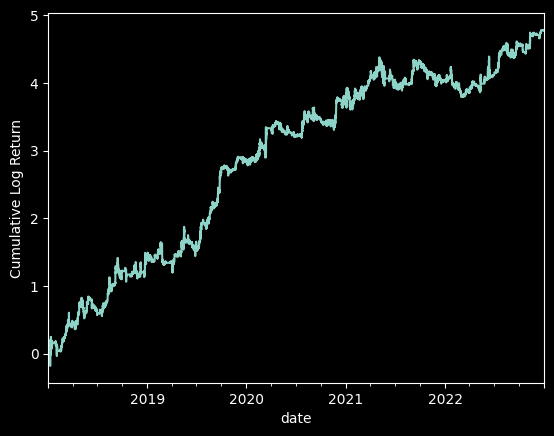

In [47]:
lookback = 24
threshold = 0.25
atr_lookback = 168
btc_cmma = cmma(btc_data, lookback, atr_lookback)
eth_cmma = cmma(eth_data, lookback, atr_lookback)

intermarket_diff = eth_cmma - btc_cmma
eth_data['sig'] = threshold_revert_signal(intermarket_diff, threshold)
rets = eth_data['sig'] * eth_data['next_return']
long_trades, short_trades, all_trades = get_trades_from_signal(eth_data, eth_data['sig'])
plt.style.use('dark_background')
rets = eth_data['sig'] * eth_data['next_return']
pf = rets[rets > 0].sum() / rets[rets<0].abs().sum()
print("Profit factor", pf)
rets.cumsum().plot()
plt.ylabel("Cumulative Log Return")


<Axes: xlabel='date'>

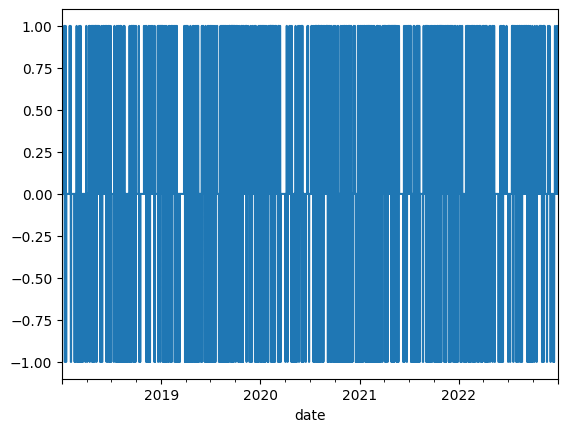

In [40]:
# Plot Signals
eth_data['sig']
eth_data['sig'].plot()


In [50]:
# Plot Returns

In [44]:
long_tr = long_trades['return']
short_tr = short_trades['return']

In [46]:
# Print Statistics
print("long trades")
print("# of trades", len(long_tr))
print("win rate", len(long_tr[long_tr > 0]) / len(long_tr) )
print("avg trade %", long_tr.mean() * 100)
print("") 
print("short trades")
print("# of trades", len(short_tr))
print("win rate", len(short_tr[short_tr > 0]) / len(short_tr) )
print("avg trade %", short_tr.mean() * 100)
average_return = rets.mean()
std_dev = rets.std()
sharpe_ratio = average_return / std_dev
sharpe_ratio


long trades
# of trades 388
win rate 0.5128865979381443
avg trade % 0.5819315538027854

short trades
# of trades 372
win rate 0.5188172043010753
avg trade % 0.6888949981048935


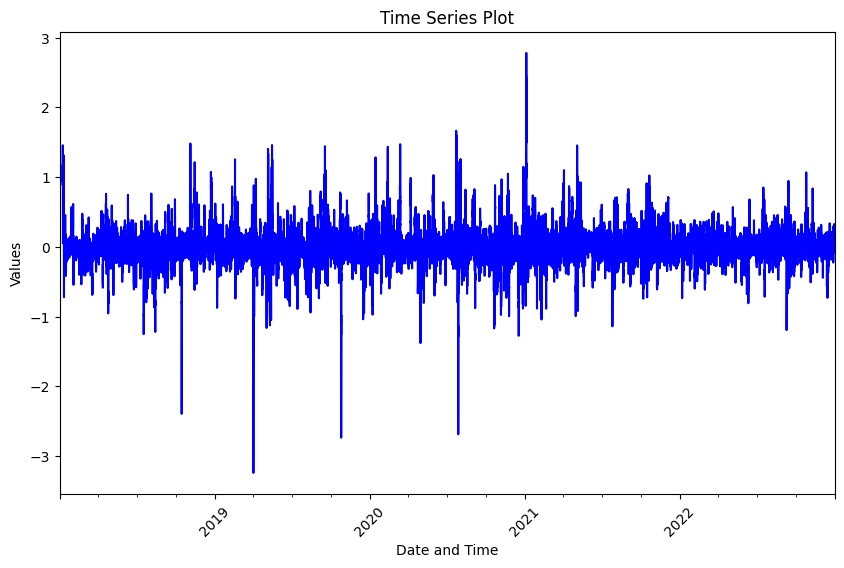

In [42]:
time_series = intermarket_diff
time_series.index = pd.to_datetime(time_series.index)

# Plotting the time series
fig, ax = plt.subplots(figsize=(10, 6))
time_series.plot(ax=ax, color='b')

plt.title('Time Series Plot')
plt.xlabel('Date and Time')
plt.ylabel('Values')

plt.xticks(rotation=45)
plt.show()